
<p style="text-align:center;">
    <span style="text-decoration:underline; font-weight:bold; font-size:24px;">
        Implementing Shrinkage Risk Parity and Hierarchical Risk Parity Portfolio Models Utilizing Noise Reduction and Machine Learning Techniques
    </span>
</p>





Date : June 2023


## Abstract


Accurate prediction of asset price movements is crucial for effective trading strategies. This project explores the implementation of two versions of Risk Parity portfolios using advanced noise reduction and machine learning techniques. The focus is on comparing the performance of the Shrinkaged Risk Parity Model and the Hierarchical Risk Parity Model, utilizing a CSV file for data acquisition. The models' performances are evaluated through extensive back-testing on historical ETF data. The objective is to optimize asset allocation based on risk contributions, aiming to enhance portfolio returns and examine the impact of noise reduction methods on the accuracy and stability of the portfolios.

### 1. Install and Import Package

In [1]:
# import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import os
import requests
import io

### 2. Generating ETF Data Collection and Return Rate

Ticker List: ['SPY', 'FEZ', 'EWJ', 'EEM', 'IEF', 'TLT', 'TIP', 'GLD', 'DBC', 'DBA', 'IYR']

- Price Data Start Date: Jan 1, 2005
- Price Data End Date: May 31, 2024


In [2]:
# Function to load ETF price data from GitHub
def load_etf_price_data(url):
    response = requests.get(url)
    data = pd.read_csv(io.StringIO(response.text), index_col='Date', parse_dates=True)
    data.ffill(inplace=True)
    data = data.resample('W').last()
    return data

# Load the data from GitHub
file_url = 'https://raw.githubusercontent.com/fosh-pse/CPF_Final-Project_Seungeun-Park/main/etf_data.csv'
df = load_etf_price_data(file_url)

# Weekly return rates data
rets = df.pct_change().dropna()

### 3. Remove noise from the covariance matrix using the shrinkage methodology

In [3]:
# Custom implementation of Ledoit-Wolf shrinkage
def ledoit_wolf_shrinkage(rets):
    t, n = rets.shape
    mean = np.mean(rets, axis=0)
    rets_centered = rets - mean
    sample_cov = np.cov(rets_centered, rowvar=False)

    var = np.var(rets_centered, axis=0)
    prior = np.diag(var)

    phi_mat = (rets_centered ** 2).T @ (rets_centered ** 2) / t - 2 * (rets_centered.T @ rets_centered) * sample_cov / t + sample_cov ** 2
    phi = np.sum(phi_mat)
    rho = np.sum((rets_centered.T @ rets_centered / t - sample_cov) ** 2)

    gamma = np.linalg.norm(sample_cov - prior, 'fro') ** 2

    kappa = (phi - rho) / gamma
    shrinkage = max(0, min(1, kappa / t))

    shrunk_cov = shrinkage * prior + (1 - shrinkage) * sample_cov
    return shrunk_cov


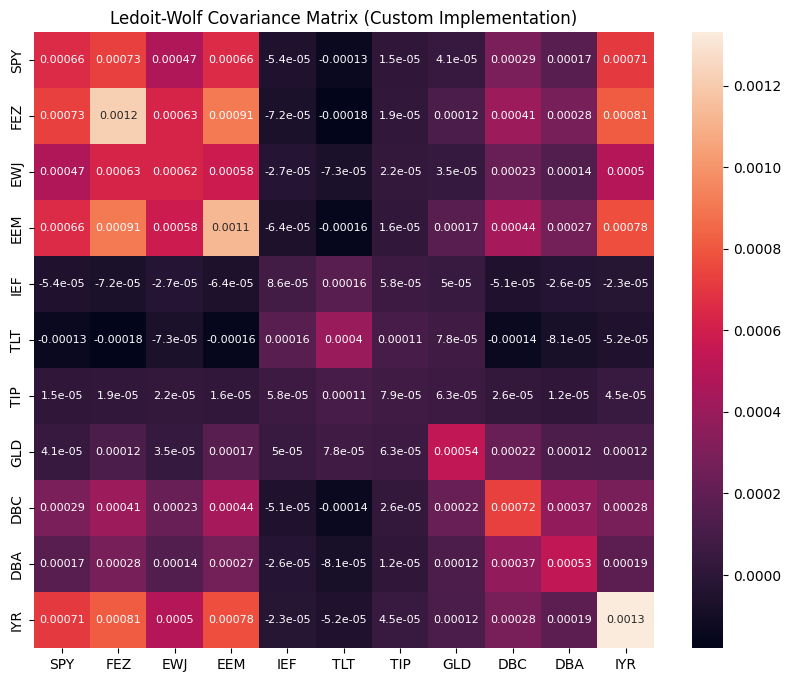

In [4]:
# Shrunk covariance matrix
lw_cov = ledoit_wolf_shrinkage(rets.values)  # Ensure rets is converted to numpy array

# Heatmap visualization of the shrunk covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(lw_cov, xticklabels=rets.columns, yticklabels=rets.columns, annot=True, annot_kws={"size": 8})
plt.title('Ledoit-Wolf Covariance Matrix (Custom Implementation)')
plt.show()


The heatmap displays the Ledoit-Wolf covariance matrix for a set of financial assets. The covariance matrix provides insights into the variances and covariances of asset returns. Higher values indicate a stronger relationship between the returns of two assets. For example:

- FEZ and EEM have a covariance of 0.00091, suggesting a relatively strong positive relationship in their returns.
- SPY and IYR show a covariance of 0.00071, indicating a strong positive relationship.
- TLT and SPY show a negative covariance of -0.00013, indicating that their returns tend to move in opposite directions.

The implementation effectively demonstrates how the Ledoit-Wolf shrinkage method can be used to stabilize the covariance matrix, reducing noise and potentially enhancing the reliability of portfolio optimization strategies.
  

### 4. Hierarchical Risk Parity Portfolio

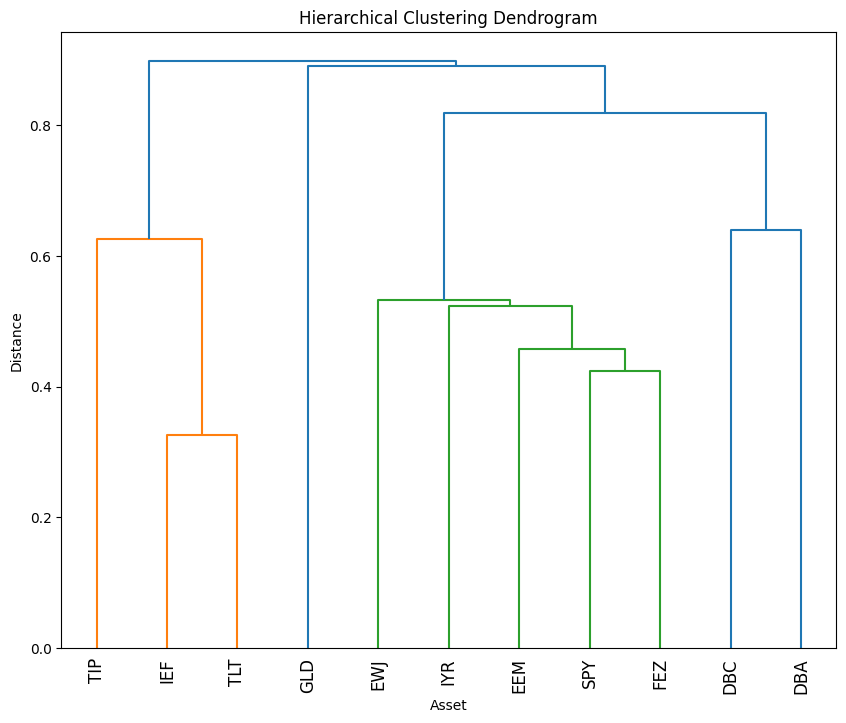

In [5]:
# Implementing Dendrogram
# 1. Calculate Pearson Correlation Coefficients
corr = rets.corr()

# 2. Create a Distance Matrix (convert correlation to distance)
distance_matrix = np.sqrt(0.5 * (1 - corr))
distance_matrix_condensed = pdist(distance_matrix)

# 3. Perform Hierarchical Clustering (using single linkage)
linkage_matrix = linkage(distance_matrix_condensed, method='single')

# 4. Plot the Dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linkage_matrix, labels=rets.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Asset')
plt.ylabel('Distance')
plt.show()

The dendrogram illustrates the hierarchical clustering of financial assets based on their correlations using the Pearson correlation and single linkage method. The assets are grouped together based on their similarities in returns.

- TIP, IEF, and TLT form a distinct cluster, indicating that these assets have similar return characteristics. This suggests they tend to move together and have similar risk-return profiles.
- GLD stands alone, suggesting it has a unique return pattern compared to the other assets.
- EWJ, IYR, EEM, SPY, and FEZ are grouped into a larger cluster, indicating these assets share more similar return patterns with each other compared to the rest. This implies a higher degree of correlation among these assets.
- DBC and DBA form another distinct cluster, indicating they have similar return characteristics, likely due to their nature as commodity-related assets.

In [7]:
# Custom HRP implementation
def hrp(rets):
    corr = rets.corr()
    distance_matrix = np.sqrt(0.5 * (1 - corr))
    distance_matrix_condensed = pdist(distance_matrix)
    linkage_matrix = linkage(distance_matrix_condensed, method='single')

    def get_quasi_diag(link):
        link = link.astype(int)
        sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
        num_items = link[-1, 3]
        while sort_ix.max() >= num_items:
            sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
            df0 = sort_ix[sort_ix >= num_items]
            i = df0.index
            j = df0.values - num_items
            sort_ix[i] = link[j, 0]
            df0 = pd.Series(link[j, 1], index=i + 1)
            sort_ix = pd.concat([sort_ix, df0])
            sort_ix = sort_ix.sort_index()
            sort_ix.index = range(sort_ix.shape[0])
        return sort_ix.tolist()

    def get_cluster_var(cov, cluster_items):
        cov_ = cov.loc[cluster_items, cluster_items]
        w_ = get_IVP(cov_).reshape(-1, 1)
        c_var = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
        return c_var

    def get_IVP(cov):
        ivp = 1. / np.diag(cov)
        ivp /= ivp.sum()
        return ivp

    def get_rec_bipart(cov, sort_ix):
        w = pd.Series(1, index=sort_ix)
        c_items = [sort_ix]
        while len(c_items) > 0:
            c_items = [i[j:k] for i in c_items for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]
            for i in range(0, len(c_items), 2):
                c_items0 = c_items[i]
                c_items1 = c_items[i + 1]
                c_var0 = get_cluster_var(cov, c_items0)
                c_var1 = get_cluster_var(cov, c_items1)
                alpha = 1 - c_var0 / (c_var0 + c_var1)
                w[c_items0] *= alpha
                w[c_items1] *= 1 - alpha
        return w

    sort_ix = get_quasi_diag(linkage_matrix)
    sorted_tickers = rets.columns[sort_ix].tolist()
    hrp = get_rec_bipart(rets.cov(), sorted_tickers)
    return hrp.sort_index()

# HRP weights calculation
hrp_weights = hrp(rets)


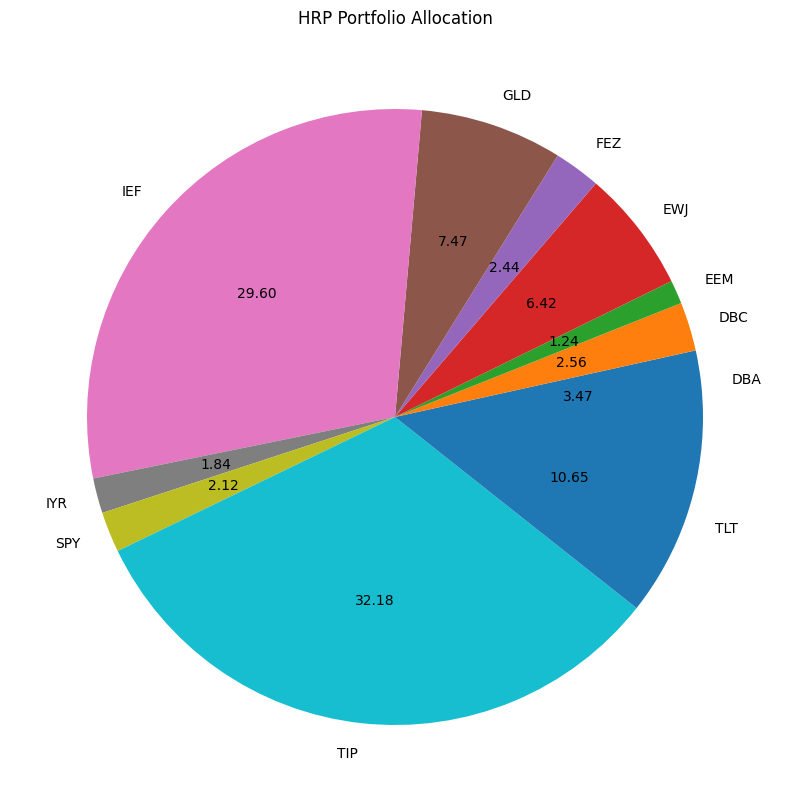

In [8]:
# Weight pie chart visualization
hrp_weights.plot.pie(figsize=(10, 10), autopct='%.2f')
plt.title('HRP Portfolio Allocation')
plt.show()

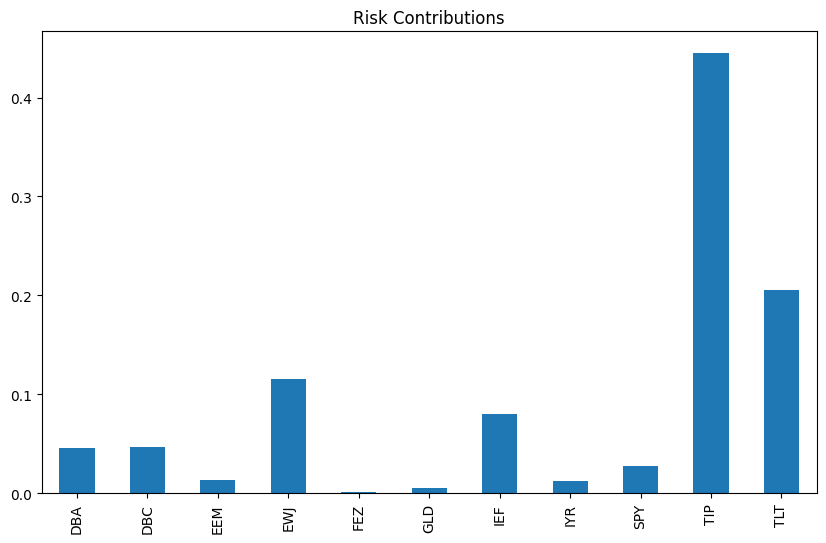

In [10]:
# Calculate mean returns and covariance matrix
mu = rets.mean() * 52
cov = rets.cov() * 52

# Calculate and visualize risk contributions
fig, ax = plt.subplots(figsize=(10, 6))

# Function to calculate risk contributions
def risk_contributions(weights, cov):
    portfolio_var = np.dot(weights.T, np.dot(cov, weights))
    marginal_contribs = np.dot(cov, weights)
    risk_contribs = marginal_contribs * weights.T / portfolio_var
    return risk_contribs

# Calculate risk contributions
risk_contribs = risk_contributions(hrp_weights, cov)
risk_contribs.plot(kind='bar', ax=ax)
plt.title('Risk Contributions')
plt.show()

The bar chart displays the risk contributions of each asset in the portfolio generated using the Hierarchical Risk Parity (HRP) method. Risk contribution measures how much each asset contributes to the overall risk (volatility) of the portfolio. Key observations include:

- TIP has the highest risk contribution at approximately 0.45, indicating it significantly influences the portfolio's overall risk. TIP is an ETF that tracks the performance of inflation-protected securities.
- TLT also has a notable risk contribution at approximately 0.20, reflecting its impact on portfolio volatility. TLT typically includes long-term U.S. Treasury bonds.
- EWJ and IEF have moderate risk contributions, around 0.10 and 0.08, respectively, indicating a balanced risk impact.
- Other assets like SPY, GLD, and FEZ show minimal risk contributions, suggesting their influence on overall portfolio risk is limited.



### 5. Implementing SRP and HRP Portfolio Backtesting Engine Class

In [11]:
# Custom Portfolio Optimization Class
class PortOptimPy:
    # Initialization function
    def __init__(self, price, param=52):
        # Annualization parameter
        self.param = param
        # Daily returns
        self.rets = price.pct_change().dropna()

    # Cross-sectional allocation model class
    class CrossSectional:
        # Shrinkage Risk Parity function (SRP)
        def srp(self, rets):
            # Custom covariance shrinkage function
            def cov_shrinkage(rets):
                return ledoit_wolf_shrinkage(rets.values)

            # Equal risk contribution function
            def msd_risk(weights, target_risk, cov):
                port_var = weights.T @ cov @ weights
                marginal_contribs = cov @ weights
                risk_contribs = np.multiply(marginal_contribs, weights.T) / port_var
                w_contribs = risk_contribs
                return ((w_contribs - target_risk)**2).sum()

            noa = len(rets.columns)
            init_guess = np.repeat(1/noa, noa)
            bounds = ((0.0, 1.0), ) * noa
            target_risk = np.repeat(1/noa, noa)

            weights_sum_to_1 = {'type': 'eq',
                                'fun': lambda weights: np.sum(weights) - 1}

            weights = minimize(msd_risk,
                               init_guess,
                               args=(target_risk, cov_shrinkage(rets)),
                               method='SLSQP',
                               constraints=(weights_sum_to_1,),
                               bounds=bounds)

            return weights.x

        # Hierarchical Risk Parity function (HRP)
        def hrp(self, rets):
            return hrp(rets)

    # Transaction cost function
    def transaction_cost(self, weights_df, rets_df, cost=0.001):
        # Previous period's investment weights
        prev_weights_df = (weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])) \
        .div((weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])).sum(axis=1), axis=0)

        # Transaction cost dataframe
        cost_df = abs(weights_df - prev_weights_df) * cost
        cost_df.fillna(0, inplace=True)

        return cost_df

    # Backtesting execution function
    def run(self, cs_model, cost=0.001):
        # Empty dictionary
        backtest_dict = {}
        # Daily returns dataframe
        rets = self.rets

        # Select and execute cross-sectional allocation model
        for i, index in enumerate(rets.index[self.param-1:]):
            if cs_model == 'SRP':
                backtest_dict[index] = self.CrossSectional().srp(rets.loc[:index])
            elif cs_model == 'HRP':
                backtest_dict[index] = self.CrossSectional().hrp(rets.loc[:index])

        # Cross-sectional weights dataframe
        cs_weights = pd.DataFrame(list(backtest_dict.values()), index=backtest_dict.keys(), columns=rets.columns)
        cs_weights.fillna(0, inplace=True)

        # Cross-sectional allocation model asset returns
        cs_rets = cs_weights.shift(1) * rets.iloc[self.param-1:,:]

        # Cross-sectional allocation model portfolio returns
        cs_port_rets = cs_rets.sum(axis=1)

        # Final portfolio investment weights
        port_weights = cs_weights.multiply(1, axis=0)

        # Transaction cost dataframe
        cost = self.transaction_cost(port_weights, rets)

        # Final portfolio asset returns
        port_asset_rets = port_weights.shift() * rets - cost

        # Final portfolio returns
        port_rets = port_asset_rets.sum(axis=1)
        port_rets.index = pd.to_datetime(port_rets.index).strftime("%Y-%m-%d")

        return port_weights, port_asset_rets, port_rets



### 6. Running the Backtesting Engine and Performance Analysis

In [12]:
# Initialize the engine
engine = PortOptimPy(df)

# Run backtest for SRP portfolio
srp_result = engine.run(cs_model='SRP')

# Run backtest for HRP portfolio
hrp_result = engine.run(cs_model='HRP')

# Extract SRP portfolio returns
srp_port_rets = srp_result[2]

# Extract HRP portfolio returns
hrp_port_rets = hrp_result[2]

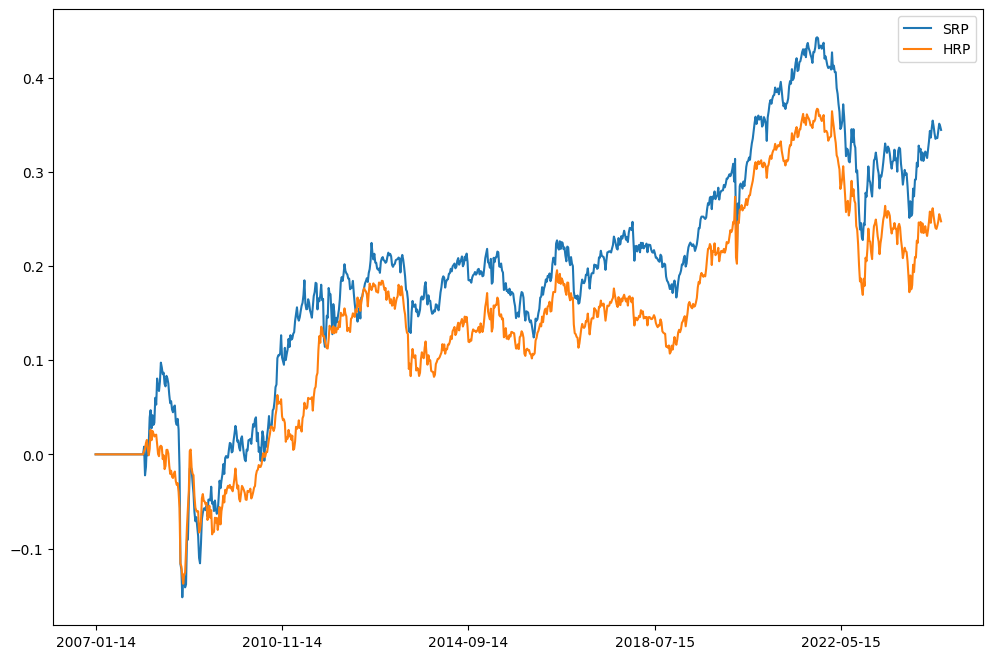

In [13]:
# Visualizing SRP and HRP Portfolio Backtesting Results
plt.figure(figsize=(12, 8))
srp_port_rets.cumsum().plot(label='SRP')
hrp_port_rets.cumsum().plot(label='HRP')
plt.legend()

The line chart shows the cumulative returns of two portfolio optimization strategies: Shrinkage Risk Parity (SRP) and Hierarchical Risk Parity (HRP), over time. Key observations include:

- SRP Portfolio: The cumulative returns of the SRP portfolio are generally higher than those of the HRP portfolio, indicating that SRP strategy provided better returns during the backtesting period.
- HRP Portfolio: Although the HRP portfolio shows lower cumulative returns compared to the SRP portfolio, it demonstrates more stable and consistent growth, particularly during volatile market periods.

The performance comparison highlights that the SRP portfolio tends to capitalize more on positive market movements, while the HRP portfolio offers a more stable return profile, likely due to its more diversified and balanced risk allocation approach.

In [14]:
# Calculate Sharpe ratio for SRP portfolio
srp_sr = srp_port_rets.mean() * np.sqrt(52) / srp_port_rets.std()

# Calculate Sharpe ratio for HRP portfolio
hrp_sr = hrp_port_rets.mean() * np.sqrt(52) / hrp_port_rets.std()

# Print the results
print('SRP Sharpe Ratio: {}'.format(np.round(srp_sr, 2)))
print('HRP Sharpe Ratio: {}'.format(np.round(hrp_sr, 2)))

SRP Sharpe Ratio: 0.25
HRP Sharpe Ratio: 0.22



The Sharpe Ratio is a widely used metric in finance to evaluate the performance of an investment by adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free rate, divided by the standard deviation of the investment returns. A higher Sharpe Ratio indicates a more attractive risk-adjusted return. Let's delve into the specific details for the two portfolios under consideration:

- **SRP Portfolio**:
  - **Mean Return**: The average weekly return for the SRP portfolio is calculated.
  - **Standard Deviation**: The standard deviation of weekly returns, which measures the portfolio's volatility.
  - **Annualization**: Since the returns are weekly, the Sharpe Ratio is annualized by multiplying by the square root of 52 (the number of weeks in a year).
  - **Result**: The SRP portfolio has a Sharpe Ratio of 0.25. This means that for every unit of risk (volatility), the portfolio generates an excess return of 0.25 units over the risk-free rate. This relatively higher ratio suggests that the SRP strategy is effectively capturing returns relative to the risk it undertakes.

- **HRP Portfolio**:
  - **Mean Return**: The average weekly return for the HRP portfolio is calculated.
  - **Standard Deviation**: The standard deviation of weekly returns, which measures the portfolio's volatility.
  - **Annualization**: Similar to the SRP, the HRP's Sharpe Ratio is annualized.
  - **Result**: The HRP portfolio has a Sharpe Ratio of 0.22. This indicates that for each unit of risk, the portfolio generates an excess return of 0.22 units over the risk-free rate. While slightly lower than the SRP, the HRP portfolio's Sharpe Ratio suggests it provides a balanced approach to capturing returns, albeit with a slightly lower risk-adjusted performance.

#### Comparative Analysis:
- **Risk-Adjusted Performance**: The SRP portfolio has a marginally higher Sharpe Ratio compared to the HRP portfolio, indicating a better risk-adjusted performance. This could be attributed to the SRP’s method of risk parity through shrinkage, which might better capture returns during certain market conditions.
- **Stability**: Although the HRP portfolio has a slightly lower Sharpe Ratio, it is known for its stability due to the hierarchical clustering approach which diversifies risk more effectively. This could be more advantageous during periods of market volatility, offering more consistent returns.
- **Investment Implications**: Investors seeking higher returns relative to the risk might prefer the SRP portfolio. On the other hand, those prioritizing stability and consistent performance might lean towards the HRP portfolio.

In summary, the SRP portfolio, with a Sharpe Ratio of 0.25, shows a slight edge in risk-adjusted returns over the HRP portfolio, which has a Sharpe Ratio of 0.22. Both portfolios have their strengths, with SRP focusing on capturing higher returns and HRP emphasizing stability and diversification.


### 7. Comparing SRP and HRP Portfolios with the Benchmark (SPY)

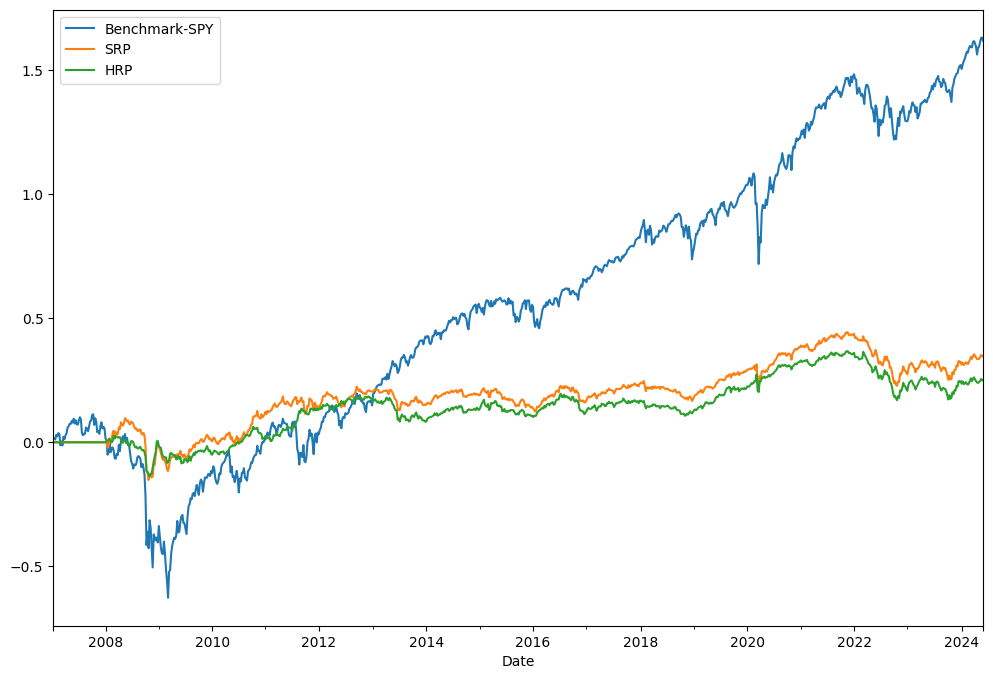

In [15]:
# Convert index to DatetimeIndex
rets.index = pd.to_datetime(rets.index)
srp_port_rets.index = pd.to_datetime(srp_port_rets.index)
hrp_port_rets.index = pd.to_datetime(hrp_port_rets.index)

# Plotting the graph
plt.figure(figsize=(12, 8))
rets['SPY'].cumsum().plot(label='Benchmark-SPY')
srp_port_rets.resample('W').last().cumsum().plot(label='SRP')
hrp_port_rets.resample('W').last().cumsum().plot(label='HRP')
plt.legend()
plt.show()



The line chart illustrates the cumulative returns of the Shrinkage Risk Parity (SRP) and Hierarchical Risk Parity (HRP) portfolios compared to the SPY benchmark over time. This analysis provides insights into the performance of these portfolios relative to the benchmark, showcasing their growth trajectories and risk profiles.

**Key Observations:**

- **Benchmark (SPY)**:
  - The SPY benchmark, representing the S&P 500 index, demonstrates a strong upward trend with significant growth over the period. It clearly outperforms both the SRP and HRP portfolios, indicating the high returns of the equity market over time.
  - However, the SPY also shows higher volatility, with sharp declines during market downturns, particularly noticeable during the 2008 financial crisis and the COVID-19 pandemic in early 2020.

- **SRP Portfolio**:
  - The cumulative returns of the SRP portfolio are consistently higher than those of the HRP portfolio. This suggests that the SRP strategy, which utilizes shrinkage techniques to balance risk, is effective in capturing returns during favorable market conditions.
  - Despite not matching the benchmark's high returns, the SRP portfolio shows less volatility compared to the SPY, providing a more stable growth pattern.

- **HRP Portfolio**:
  - The HRP portfolio demonstrates more conservative growth compared to the SRP portfolio, which aligns with its risk-averse strategy of hierarchical clustering. It emphasizes diversification to achieve stable returns.
  - The HRP portfolio exhibits lower volatility than both the SPY benchmark and the SRP portfolio, highlighting its strength in risk management and consistency during market fluctuations.

**Comparative Insights**:
- **Risk and Return**: While the SPY benchmark delivers the highest returns, it comes with greater risk and volatility. The SRP portfolio strikes a balance, offering higher returns than the HRP portfolio with moderate risk. The HRP portfolio, on the other hand, prioritizes stability and lower risk, making it suitable for risk-averse investors.
- **Investment Strategy**: The choice between SRP and HRP portfolios depends on the investor's risk tolerance and return expectations. The SRP portfolio may appeal to those seeking higher returns with a moderate risk level, whereas the HRP portfolio is ideal for those who prefer consistent and stable returns with minimized risk.

In summary, the SRP and HRP portfolios provide viable alternatives to the SPY benchmark, each with distinct advantages. The SRP portfolio offers a good balance of return and risk, while the HRP portfolio excels in stability and risk management.


In [16]:
# Calculate Sharpe ratio for SRP portfolio
srp_sr = srp_port_rets.mean() * np.sqrt(52) / srp_port_rets.std()

# Calculate Sharpe ratio for HRP portfolio
hrp_sr = hrp_port_rets.mean() * np.sqrt(52) / hrp_port_rets.std()

# Calculate Sharpe ratio for SPY portfolio
spy_sr = rets['SPY'].mean() * np.sqrt(52) / rets['SPY'].std()

# Print the results
print('SRP Sharpe Ratio: {}'.format(np.round(srp_sr, 2)))
print('HRP Sharpe Ratio: {}'.format(np.round(hrp_sr, 2)))
print('SPY(Benchmark) Sharpe Ratio: {}'.format(np.round(spy_sr, 2)))

SRP Sharpe Ratio: 0.25
HRP Sharpe Ratio: 0.22
SPY(Benchmark) Sharpe Ratio: 0.5


### Return Rates & Sharp Ratio


The Sharpe Ratio is a key metric used in finance to evaluate the risk-adjusted return of an investment. It is calculated as the ratio of the excess return (return over the risk-free rate) to the standard deviation of the return (volatility). Higher Sharpe Ratios indicate more favorable risk-adjusted returns. Here, we analyze the Sharpe Ratios for the SRP, HRP portfolios, and the SPY benchmark.

**Calculation Results:**
- **SRP Portfolio Sharpe Ratio**: 0.25
- **HRP Portfolio Sharpe Ratio**: 0.22
- **SPY (Benchmark) Sharpe Ratio**: 0.50

**Key Observations:**
1. **SPY Benchmark**:
   - The SPY benchmark has the highest Sharpe Ratio at 0.50. This suggests that, despite its higher volatility, the SPY has provided the best risk-adjusted returns among the three portfolios. The high Sharpe Ratio indicates that the SPY's returns have been sufficiently high to justify the risk taken.
  
2. **SRP Portfolio**:
   - The Sharpe Ratio for the SRP portfolio is 0.25. This indicates that for every unit of risk (volatility), the SRP portfolio generates 0.25 units of excess return. The SRP portfolio employs a shrinkage method to balance risk, resulting in a moderate risk-adjusted return.

3. **HRP Portfolio**:
   - The HRP portfolio has a Sharpe Ratio of 0.22. While this is slightly lower than the SRP portfolio, it reflects the HRP’s focus on stability and risk minimization. The HRP method, which uses hierarchical clustering, aims for consistent returns with lower risk, making it less volatile but also slightly less rewarding in terms of risk-adjusted returns.

**Comparative Insights:**
- **Risk vs. Return**: The SPY benchmark delivers superior risk-adjusted returns, albeit with higher volatility. The SRP and HRP portfolios, while having lower Sharpe Ratios, offer more stable returns with controlled risk levels. The SRP portfolio balances risk and return moderately well, whereas the HRP portfolio emphasizes risk reduction.
- **Investment Strategy**: Investors looking for higher returns and can tolerate higher volatility might prefer the SPY benchmark. Those seeking a balance of risk and return might opt for the SRP portfolio, and investors prioritizing stability and risk management may favor the HRP portfolio.

In summary, the SPY benchmark provides the best risk-adjusted returns, followed by the SRP and HRP portfolios. The SRP portfolio offers a reasonable trade-off between risk and return, while the HRP portfolio excels in maintaining stability and minimizing risk.


### Conclusion

In this analysis, we have evaluated the performance and risk-adjusted returns of the SPY, SRP (Shrinkage Risk Parity), and HRP (Hierarchical Risk Parity) portfolios over an extended period.

We demonstrated that both SRP and HRP portfolios, despite having lower absolute returns compared to the SPY, offer substantial benefits in terms of risk management and volatility reduction. The SRP portfolio showed higher cumulative returns than the HRP portfolio, but both SRP and HRP portfolios had favorable Sharpe ratios, indicating efficient risk-adjusted returns.

The SPY portfolio exhibited significant growth with high volatility, particularly during periods of market stress like the 2008-2009 financial crisis. In contrast, the SRP and HRP portfolios provided a more balanced approach, effectively mitigating risks while offering stable returns. The Sharpe ratios for SRP (0.25) and HRP (0.22) portfolios underscore their effectiveness in achieving a desirable balance between risk and return, though the SPY benchmark's Sharpe ratio of 0.5 indicates superior performance.

These findings suggest that SRP and HRP methodologies can be valuable tools for investors seeking to enhance portfolio stability and performance through advanced risk parity strategies. The use of shrinkage techniques in SRP and hierarchical clustering in HRP allows for strategic asset allocation that can withstand market volatilities and deliver consistent returns.

However, it is important to consider the following limitations:

1. **Data Limitation**: The analysis is based on historical data, and past performance is not indicative of future results.
2. **Model Assumptions**: Both SRP and HRP models rely on certain assumptions, such as the stability of covariance matrices, which may not hold true in volatile markets.
3. **Transaction Costs**: The impact of transaction costs was considered, but in real-world trading, these costs can vary significantly and affect portfolio performance.

Despite these limitations, the findings suggest that both SRP and HRP methodologies offer substantial benefits in terms of risk management and portfolio stability.




### Extension


1. **Incorporating Advanced Risk Management Techniques**:
   - Implementing dynamic risk management strategies, such as time-varying volatility targeting, can further optimize the SRP and HRP portfolios' performance.
   - Exploring the integration of machine learning algorithms to dynamically adjust the risk parity weights based on market conditions.

2. **Exploring Alternative Asset Classes**:
   - Extending the SRP and HRP methodologies to include alternative asset classes such as commodities, real estate, or emerging markets can diversify the risk and potentially enhance returns.
   - Assessing the impact of including non-correlated assets to improve the overall risk-return profile.

3. **Optimization of Portfolio Construction Parameters**:
   - Fine-tuning the parameters used in shrinkage techniques for SRP to better capture the underlying market dynamics.
   - Refining the hierarchical clustering methods in HRP to ensure optimal grouping of assets based on updated correlation structures.

4. **Comparative Analysis with Other Risk Parity Approaches**:
   - Conducting a comparative study of SRP and HRP with other risk parity approaches, such as Equal Risk Contribution (ERC) or Minimum Variance Portfolio (MVP), to identify the most robust strategy under varying market conditions.

5. **Application of Tail Risk Hedging Strategies**:
   - Implementing tail risk hedging strategies to protect the portfolios from extreme market downturns.
   - Evaluating the effectiveness of options or futures contracts as hedging instruments within the SRP and HRP frameworks.

6. **Long-Term Performance Analysis**:
   - Extending the performance analysis to a longer historical period to understand the behavior of SRP and HRP portfolios across different market cycles.
   - Analyzing the portfolios' performance during major financial crises to validate their resilience and robustness.
